# Implementation of an LSTM with no HPO

Just to verify the environment works and get the RD done.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm

In [3]:
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

CUDA available: True
GPU name: Tesla V100S-PCIE-32GB


### Read in data

In [10]:
# Read in data
years = ["2020", "2021", "2022", "2023", "2024"]
columns = ["ISO Time", "Temperature (C)", "Humidity (%)", "Pressure (kPa)", "Air Quality (Ohms)"]
all_data = pd.read_csv("./data/2019_BME680SensorData.csv", usecols=columns)

for year in years:
    data_filename = f"./data/{year}_BME680SensorData.csv"
    read_in_data = pd.read_csv(data_filename, usecols=columns)
    all_data = pd.concat([all_data, read_in_data], ignore_index=True)

print("Data Collected")
all_data.head()


all_data["ISO Time"] = pd.to_datetime(all_data["ISO Time"])
all_data.set_index("ISO Time", inplace=True)
hourly_avg = all_data.resample("H").mean()


Data Collected


### Basic Visualization

We'll just look at temp for now.

<Figure size 1400x500 with 0 Axes>

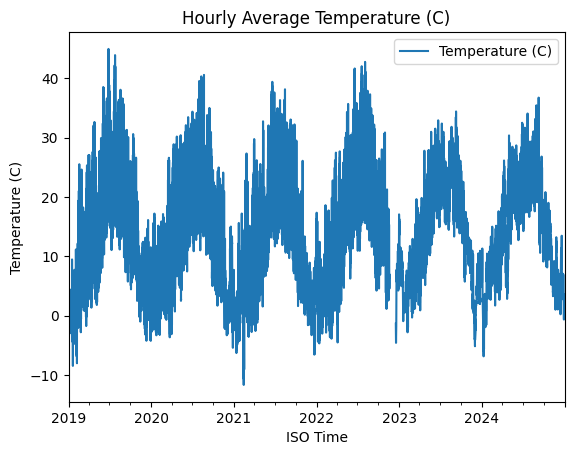

<Figure size 1400x500 with 0 Axes>

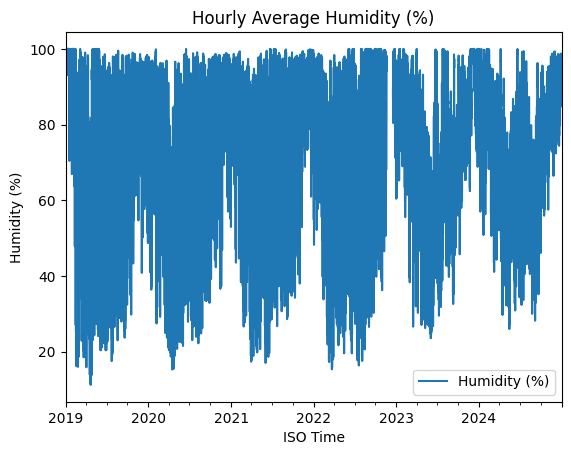

<Figure size 1400x500 with 0 Axes>

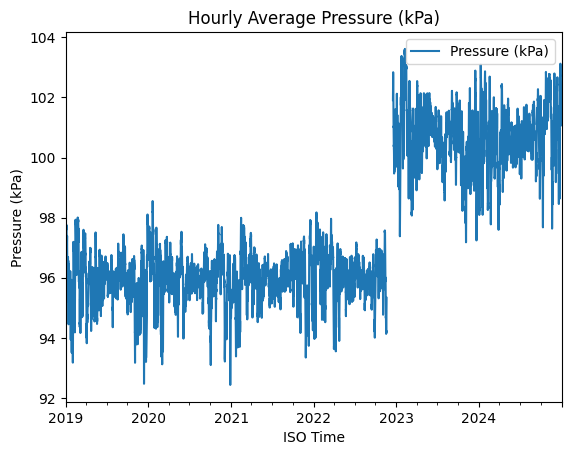

<Figure size 1400x500 with 0 Axes>

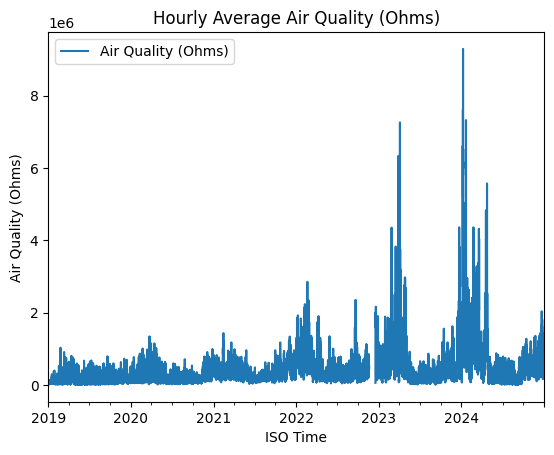

In [12]:
var_names = columns[1:]

for variable in var_names:
    plt.figure(figsize=(14, 5))
    hourly_avg.plot(y=variable)
    plt.title(f"Hourly Average {variable}")
    plt.ylabel(variable)
    plt.show()



### Model definition and training

In [13]:
data = hourly_avg["Temperature (C)"].dropna()
data

ISO Time
2019-01-01 00:00:00    4.293500
2019-01-01 01:00:00    4.125000
2019-01-01 02:00:00    4.056333
2019-01-01 03:00:00    3.946500
2019-01-01 04:00:00    3.739667
                         ...   
2024-12-31 19:00:00    3.260667
2024-12-31 20:00:00    3.269362
2024-12-31 21:00:00    3.188462
2024-12-31 22:00:00    3.008491
2024-12-31 23:00:00    2.883103
Name: Temperature (C), Length: 51931, dtype: float64

In [18]:
# Scale Data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.to_numpy().reshape(-1,1))

# Hyper Parameters
horizon = 24
look_back = horizon * 7  # 1 week lookback
n_splits = 5
epochs = 50
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

def create_dataset(dataset, look_back, horizon=24):
    X, y = [], []
    for i in range(len(dataset) - look_back - horizon + 1):
        X.append(dataset[i:i+look_back, 0])                # Input: 168 past hours
        y.append(dataset[i+look_back : i+look_back+horizon, 0])  # Output: next 24 hours sequence
    return np.array(X), np.array(y)

X, y = create_dataset(data_scaled, look_back, horizon)
X = X[:, :, np.newaxis]  # (samples, look_back, 1)
y = y[:, :, np.newaxis]  # (samples, horizon, 1)

# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, output_size=24):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)  # output 24 values at once

    def forward(self, x):
        out, _ = self.lstm(x)           # out shape: (batch, seq_len, hidden_size)
        out = out[:, -1, :]             # take output from last time step only
        out = self.linear(out)          # map to 24 outputs
        out = out.unsqueeze(2)          # reshape to (batch, 24, 1)
        return out

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

cuda


Train

In [19]:
tscv = TimeSeriesSplit(n_splits=n_splits)
rmse_scores = []
mape_scores = []
mae_scores = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    print(f"Fold {fold+1}")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)
    X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_t = torch.tensor(y_test, dtype=torch.float32).to(device)

    train_dataset = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = LSTMModel().to(device)
    optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        with tqdm(train_loader, unit="batch", desc=f"Fold {fold+1} Epoch {epoch+1}") as tepoch:
            for xb, yb in tepoch:
                optimizer.zero_grad()
                pred = model(xb)
                loss = loss_fn(pred, yb)
                loss.backward()
                optimizer.step()
                tepoch.set_postfix(loss=loss.item())

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_t).cpu().numpy()              # shape: (num_samples, 24, 1)
        y_test_np = y_test_t.cpu().numpy()                  # shape: (num_samples, 24, 1)
        
        # Reshape for scaler inverse transform
        y_pred_reshaped = y_pred.reshape(-1, 1)             # (num_samples * 24, 1)
        y_test_reshaped = y_test_np.reshape(-1, 1)
        
        # Inverse scale
        y_pred_inv = scaler.inverse_transform(y_pred_reshaped)
        y_test_inv = scaler.inverse_transform(y_test_reshaped)
        
        # Compute metrics on flattened arrays
        rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
        mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
        mae = mean_absolute_error(y_test_inv, y_pred_inv)
        
        print(f"Fold {fold+1} RMSE: {rmse:.4f}, MAPE: {mape:.4f}, MAE: {mae:.4f}")
        rmse_scores.append(rmse)
        mape_scores.append(mape)
        mae_scores.append(mae)
    
print(f"\nAverages across folds RMSE: {np.mean(rmse_scores):.4f} MAPE: {np.mean(mape_scores)} MAE: {np.mean(mae_scores)}")

Fold 1


Fold 1 Epoch 50: 100%|██████████| 270/270 [00:00<00:00, 418.30batch/s, loss=0.00328]


Fold 1 RMSE: 3.1274, MAPE: 126.3380, MAE: 2.2377
Fold 2


Fold 2 Epoch 50: 100%|██████████| 539/539 [00:01<00:00, 347.04batch/s, loss=0.00263]


Fold 2 RMSE: 2.7837, MAPE: 94.0490, MAE: 1.9686
Fold 3


Fold 3 Epoch 50: 100%|██████████| 809/809 [00:02<00:00, 286.51batch/s, loss=0.00215] 


Fold 3 RMSE: 2.8471, MAPE: 85.5851, MAE: 2.0546
Fold 4


Fold 4 Epoch 50: 100%|██████████| 1078/1078 [00:04<00:00, 234.66batch/s, loss=0.00124]


Fold 4 RMSE: 2.6532, MAPE: 31.9692, MAE: 1.9429
Fold 5


Fold 5 Epoch 50: 100%|██████████| 1348/1348 [00:06<00:00, 207.54batch/s, loss=0.00237]


Fold 5 RMSE: 1.9708, MAPE: 41.6057, MAE: 1.4195

Averages across folds RMSE: 2.6764 MAPE: 75.90940237045288 MAE: 1.9246663570404052
